# Exploring Traditional and Deep Learning Approaches to Online Learning in NBA Game Prediction

### By Peter Wu and Jerry Sun `{plw53, js2746}@cornell.edu`

Online learning approaches have traditionally been used for prediction tasks that involve streams of new data that are increasingly relevant as recency increases. A major possible testbed for such methods is sports, where new data is well-documented. As such, we plan on evaluating several machine learning algorithms on daily sets of new data, with a specialized data collection architecture that translates complicated game data to a suitable data format for the model to train on, day by day. 

## Verifying Colab Runtime Environment Settings

Make sure we are using a high-RAM runtime and are connected to a GPU before running Hedge Backpropagation for our deep neural network.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
Thu Dec  2 23:00:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
    

## Installing Dependencies

(only run this once!)

In [ ]:
!pip3 install -U onn
!pip3 install -U imbalanced-learn

  Created wheel for onn: filename=onn-0.2.1-py3-none-any.whl size=4688 sha256=f4d5f32858783a7e3f705b9106314bd3539ea392fa53869fd432de7e510550cf
  Stored in directory: /root/.cache/pip/wheels/09/62/46/9a5dd2903d1bbefffbf53589871a629a20d6e4ddb0a9249702
  Created wheel for mabalgs: filename=mabalgs-0.6.8-py3-none-any.whl size=9712 sha256=a5db9718bee57a37fb93953f7dd3a8c448b5473009dea96b7590a9000b5f0f21
  Stored in directory: /root/.cache/pip/wheels/46/dd/ca/c9d5b1955d24d3b8b6244895e29b5dc0884f2ac538090785ea
Successfully built onn mabalgs


## Library Imports

In [ ]:
from onn.OnlineNeuralNetwork import ONN
from onn.OnlineNeuralNetwork import ONN_THS
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from imblearn.datasets import make_imbalance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## Dataset Preprocessing

In [ ]:
url = 'https://raw.githubusercontent.com/Silver-Scripters/scraper/main/final.csv'
df = pd.read_csv(url)

data_top = df.head()
data_top


# Pre-process features
columns = ['min', 'fg', 'fga', '3p', '3pa', 'ft', 'fta', 'oreb', 'dreb', 'ast', 'stl', 'blk', 'tov', 'pts']
for i in range(1, 11):
  for col in columns:
    addon = '' if i == 1 else str(i)
    df[col+addon] = (df[col+addon] - df[col+addon].min()) / df[col+addon].max()
df.insert(4, 'team1record', (df['team1_wins'] - df['team1_losses'])/82*0.5 + 0.5)
df.insert(5, 'team2record', (df['team2_wins'] - df['team2_losses'])/82*0.5 + 0.5)
df = df.loc[(df['dates'] != ' 1999') & (df['dates'] != ' 2000')]
counter = 0
curr = df['dates'].iloc[0]
for i in range(len(df)):
  if df['dates'].iloc[i] != curr:
    counter += 1
    curr = df['dates'].iloc[i]
  df['dates'].iloc[i] = counter
df = df.reset_index()

# Calculate the labels (winning team)
df['winner'] = (df['team1pts'] > df['team2pts']).astype(int)

# Drop the label constituent columns
df = df.drop(['team1pts', 'team2pts', 'team1_wins', 'team1_losses', 'team2_wins', 'team2_losses'], axis = 1)
print(df['dates'])
# pca = PCA(n_components=10)
# pca_df = df.iloc[:, :-2].to_numpy()
# pca.fit(pca_df)
# pca_df = pca.transform(pca_df)
# pca_df = pd.DataFrame(pca_df)
# print(len(pca_df))
# pca_df['dates'] = df['dates']
# pca_df['winner'] = df['winner']
pca_df = df
pca_df = pca_df.drop(['index'], axis=1)
batches = []
while len(pca_df) > 0:
  current = pca_df.loc[(pca_df['dates'] == pca_df['dates'].iloc[0])]
  batches.append(current)
  pca_df = pca_df.loc[(pca_df['dates'] != pca_df['dates'].iloc[0])]

# Ideally we have train test split for every season? or every couple years?
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
pca_df.head()
print(len(batches))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0           0
1           0
2           0
3           1
4           2
         ... 
21652    3899
21653    3900
21654    3901
21655    3902
21656    3903
Name: dates, Length: 21657, dtype: object
3904


## Baseline 1: Online Perceptron

In [ ]:
from sklearn.linear_model import Perceptron

accuracies = []
Y_test = batches[0].iloc[:, -1].to_numpy()
X_test = batches[0].iloc[:, :-2].to_numpy()
start = time.time()
for i in range(len(batches)):
    if i < len(batches) - 1:
      Y = batches[i].iloc[:, -1].to_numpy()
      X = batches[i].iloc[:, :-2].to_numpy()
    np.random.seed(42)
    estimator = Perceptron(tol=1e-3, random_state=0)
    for j in range(len(X)):
      estimator.partial_fit(np.asarray([X[j, :]]), np.asarray([Y[j]]), classes=[0, 1])
    if i % 50 == 0:
      predictions = estimator.predict(X_test)
      accuracy = accuracy_score(Y_test, predictions)
      print("Online Accuracy: {}".format(accuracy))
      accuracies.append(accuracy)
    X_test = np.concatenate((X_test, X), axis=0)
    Y_test = np.concatenate((Y_test, Y), axis=0)
end = time.time()
print("Wall Clock Time: {}".format(end - start))

Online Accuracy: 0.6666666666666666
Online Accuracy: 0.4196078431372549
Online Accuracy: 0.5905797101449275
Online Accuracy: 0.5593784683684795
Online Accuracy: 0.4015223596574691
Online Accuracy: 0.6018590240123934
Online Accuracy: 0.5786202610316967
Online Accuracy: 0.5409161091096243
Online Accuracy: 0.40638198029094325
Online Accuracy: 0.6015164279696714
Online Accuracy: 0.39791744142804014
Online Accuracy: 0.39452867501647987
Online Accuracy: 0.3925948592411261
Online Accuracy: 0.6073283323716099
Online Accuracy: 0.3927723555790029
Online Accuracy: 0.3920854576353484
Online Accuracy: 0.3919908466819222
Online Accuracy: 0.4386698964985686
Online Accuracy: 0.6099115772157104
Online Accuracy: 0.4246918335901387
Online Accuracy: 0.5989120580235721
Online Accuracy: 0.6043586109142453
Online Accuracy: 0.39596299411269975
Online Accuracy: 0.6057432968427733
Online Accuracy: 0.6060105184072127
Online Accuracy: 0.45734597156398105
Online Accuracy: 0.6062836116614775
Online Accuracy: 0.4011

(0.35, 0.62)

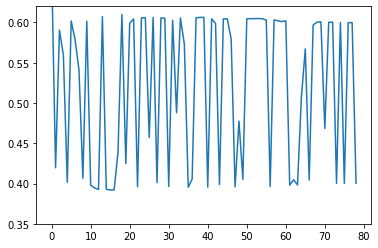

In [ ]:
plt.plot(list(range(len(accuracies))), accuracies)
plt.ylim(0.35, 0.62)

## Baseline 2: Online Logistic Regression

In [ ]:
from sklearn.linear_model import SGDClassifier

accuracies = []
Y_test = batches[0].iloc[:, -1].to_numpy()
X_test = batches[0].iloc[:, :-2].to_numpy()
start = time.time()
for i in range(len(batches)):
    if i < len(batches) - 1:
      Y = batches[i].iloc[:, -1].to_numpy()
      X = batches[i].iloc[:, :-2].to_numpy()
    np.random.seed(42)
    clf = SGDClassifier(max_iter=1000, tol=1e-3, loss='log')
    for j in range(len(X)):
      clf.partial_fit(np.asarray([X[j, :]]), np.asarray([Y[j]]), classes=[0, 1])
    if i % 50 == 0:
      predictions = clf.predict(X_test)
      accuracy = accuracy_score(Y_test, predictions)
      print("Online Accuracy: {}".format(accuracy))
      accuracies.append(accuracy)
    X_test = np.concatenate((X_test, X), axis=0)
    Y_test = np.concatenate((Y_test, Y), axis=0)
end = time.time()
print("Wall Clock Time: {}".format(end - start))

Online Accuracy: 0.3333333333333333
Online Accuracy: 0.4196078431372549
Online Accuracy: 0.5905797101449275
Online Accuracy: 0.40288568257491675
Online Accuracy: 0.4015223596574691
Online Accuracy: 0.6018590240123934
Online Accuracy: 0.4033561218147918
Online Accuracy: 0.5898095728255275
Online Accuracy: 0.40638198029094325
Online Accuracy: 0.6015164279696714
Online Accuracy: 0.39791744142804014
Online Accuracy: 0.39452867501647987
Online Accuracy: 0.3925948592411261
Online Accuracy: 0.6073283323716099
Online Accuracy: 0.6093379055658138
Online Accuracy: 0.6069434328720563
Online Accuracy: 0.3906178489702517
Online Accuracy: 0.609997797841885
Online Accuracy: 0.6099115772157104
Online Accuracy: 0.39040832049306623
Online Accuracy: 0.6065276518585675
Online Accuracy: 0.6054216867469879
Online Accuracy: 0.39596299411269975
Online Accuracy: 0.6057432968427733
Online Accuracy: 0.6060105184072127
Online Accuracy: 0.3930687203791469
Online Accuracy: 0.6062836116614775
Online Accuracy: 0.3944

(0.35, 0.62)

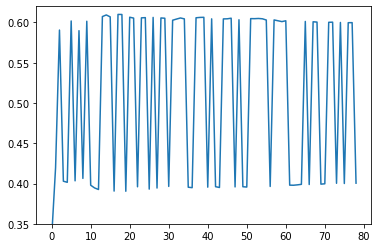

In [ ]:
plt.plot(list(range(len(accuracies))), accuracies)
plt.ylim(0.35, 0.62)

## Online Deep Learning

In [ ]:
onn_network = ONN(features_size = 142, 
                  max_num_hidden_layers = 3, 
                  qtd_neuron_per_hidden_layer = 40, 
                  n_classes = 2)

accuracies = []
test_batch = batches[3404:]
test = test_batch[0]
for i in range(1, len(test_batch)):
  test = pd.concat([test, test_batch[i]], ignore_index=True)
X_test = test.iloc[:, :-2].to_numpy()
Y_test = test.iloc[:, -1].to_numpy()
start = time.time()
for k in range(5):
  for i in range(len(batches)):
    if i < len(batches) - 500:
      Y = batches[i].iloc[:, -1].to_numpy()
      X = batches[i].iloc[:, :-2].to_numpy()
      for j in range(len(X)):
        onn_network.partial_fit(np.asarray([X[j, :]]), np.asarray([Y[j]]), show_loss=False)
      
      if i % 100 == 0:
        predictions = onn_network.predict(X_test)
        print(predictions)
        accuracy = accuracy_score(Y_test, predictions)
        print("Online Accuracy: {}".format(accuracy))
        accuracies.append(accuracy)
    else:
      break
end = time.time()
print("Wall Clock Time: {}".format(end - start))

[1 1 1 ... 1 1 1]
Online Accuracy: 0.4071207430340557
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Accuracy: 0.5928792569659442
[0 0 0 ... 0 0 0]
Online Acc

(0.56, 0.7)

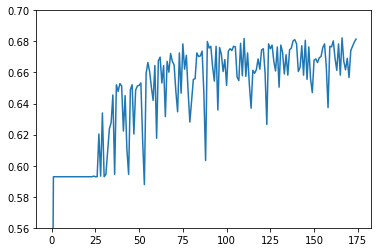

In [ ]:
plt.plot(list(range(len(accuracies))), accuracies)
plt.ylim(0.56, 0.70)

In [ ]:
 batches[0]

,team1record,team2record,min,fg,fga,3p,3pa,ft,fta,oreb,dreb,ast,stl,blk,tov,pts,min2,fg2,fga2,3p2,3pa2,ft2,fta2,oreb2,dreb2,ast2,stl2,blk2,tov2,pts2,min3,fg3,fga3,3p3,3pa3,ft3,fta3,oreb3,dreb3,ast3,...,3pa8,ft8,fta8,oreb8,dreb8,ast8,stl8,blk8,tov8,pts8,min9,fg9,fga9,3p9,3pa9,ft9,fta9,oreb9,dreb9,ast9,stl9,blk9,tov9,pts9,min10,fg10,fga10,3p10,3pa10,ft10,fta10,oreb10,dreb10,ast10,stl10,blk10,tov10,pts10,dates,winner
0,0.506098,0.493902,0.351052,0.333333,0.387387,0.148148,0.113208,0.28,0.285714,0.071429,0.092593,0.074074,0.1875,0.0,0.08,0.331429,0.258598,0.306122,0.242718,0.000000,0.000000,0.244898,0.224138,0.222222,0.156863,0.000000,0.176471,0.35,0.086957,0.320611,0.190450,0.076923,0.055556,0.0,0.00,0.044444,0.035714,0.000000,0.163265,0.08,...,0.021277,0.038462,0.036364,0.12,0.14,0.035714,0.000000,0.00,0.227273,0.093023,0.473479,0.088889,0.137931,0.000000,0.000000,0.150,0.148148,0.230769,0.434783,0.115385,0.111111,0.421053,0.272727,0.115702,0.279921,0.130435,0.142857,0.190476,0.170213,0.027027,0.031746,0.041667,0.232558,0.122449,0.0625,0.000000,0.095238,0.138211,0,1
1,0.506098,0.493902,0.275515,0.216667,0.207207,0.037037,0.094340,0.06,0.071429,0.071429,0.222222,0.222222,0.1875,0.0,0.04,0.171429,0.261277,0.285714,0.262136,0.000000,0.000000,0.142857,0.172414,0.296296,0.117647,0.212766,0.117647,0.10,0.260870,0.267176,0.489395,0.192308,0.322222,0.0,0.22,0.200000,0.196429,0.037037,0.224490,0.20,...,0.361702,0.038462,0.054545,0.16,0.34,0.160714,0.117647,0.10,0.090909,0.317829,0.677612,0.466667,0.471264,0.416667,0.534884,0.200,0.222222,0.076923,0.239130,0.096154,0.277778,0.052632,0.500000,0.495868,0.338252,0.195652,0.273810,0.000000,0.000000,0.108108,0.079365,0.208333,0.162791,0.142857,0.0625,0.277778,0.285714,0.178862,0,1
2,0.493902,0.506098,0.298120,0.066667,0.162162,0.037037,0.150943,0.02,0.017857,0.035714,0.166667,0.055556,0.1875,0.0,0.28,0.057143,0.223649,0.204082,0.213592,0.130435,0.163636,0.020408,0.051724,0.111111,0.058824,0.106383,0.235294,0.00,0.043478,0.183206,0.221210,0.096154,0.166667,0.0,0.06,0.066667,0.071429,0.037037,0.204082,0.02,...,0.000000,0.153846,0.200000,0.40,0.22,0.000000,0.000000,0.05,0.181818,0.155039,0.401722,0.200000,0.252874,0.000000,0.000000,0.075,0.148148,0.230769,0.195652,0.019231,0.111111,0.105263,0.227273,0.173554,0.647920,0.586957,0.607143,0.000000,0.000000,0.270270,0.174603,0.208333,0.232558,0.142857,0.0000,0.000000,0.333333,0.520325,0,0


## Experiment 2

In [ ]:
network_size = 40
linear_input = 142
class NN(torch.nn.Module):
  def __init__(self, linear_input, network_size):
      super(NN, self).__init__()
      self.fc1 = torch.nn.Linear(linear_input, network_size)
      self.relu = torch.nn.LeakyReLU(0.1)
      self.fc2 = torch.nn.Linear(network_size, network_size)
      self.relu = torch.nn.LeakyReLU(0.1)
      self.fc3 = torch.nn.Linear(network_size, network_size)
      self.relu = torch.nn.LeakyReLU(0.1)
      self.fc4 = torch.nn.Linear(network_size, 1)
      self.sigmoid = torch.nn.Sigmoid()
  def forward(self, x):
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      x = self.relu(x)
      x = self.fc4(x)
      x = self.sigmoid(x)
      return x


In [ ]:
def train(model, loss, optimizer):
  training = []
  accuracies = []
  test_batch = batches[3404:]
  test = test_batch[0]
  for i in range(1, len(test_batch)):
    test = pd.concat([test, test_batch[i]], ignore_index=True)
  X_test = torch.from_numpy(test.iloc[:, :-2].to_numpy()).float()
  Y_test = test.iloc[:, -1].to_numpy()
  train_batch = batches[:3404]
  train = train_batch[0]
  for i in range(1, len(train_batch)):
    train = pd.concat([train, train_batch[i]], ignore_index=True)
  X = torch.from_numpy(train.iloc[:, :-2].to_numpy()).float()
  Y = torch.from_numpy(train.iloc[:, -1].to_numpy()).float()


  start = time.time()
  for i in range(500):
    train_loss = 0
    model.train()
    preds = model(X)
    loss_ = loss(preds.squeeze(), Y)
    train_loss += loss_.item()
    optimizer.zero_grad()
    loss_.backward()
    optimizer.step()
    training.append(train_loss)
    if i % 10 == 0:
      with torch.no_grad():
        model.eval()
        preds = torch.round(model(X_test)).numpy()
        correct = 0
        for pred in range(len(preds)):
          correct += preds[pred] == Y_test[pred]
        accuracy = correct / len(X_test)
      print("Training Loss: {}".format(loss_.item()))
      print("Online Accuracy: {}".format(accuracy[0]))
      accuracies.append(accuracy[0])

  end = time.time()
  print("Wall Clock Time: {}".format(end - start))
  return accuracies, training

In [ ]:
model = NN(linear_input, network_size)
loss = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.08, momentum=0.3)
accuracies, training = train(model, loss, optimizer)

Training Loss: 0.6970170736312866
Online Accuracy: 0.4071207430340557
Training Loss: 0.695509135723114
Online Accuracy: 0.461687306501548
Training Loss: 0.6936675310134888
Online Accuracy: 0.593266253869969
Training Loss: 0.6918498873710632
Online Accuracy: 0.5928792569659442
Training Loss: 0.6901534199714661
Online Accuracy: 0.5928792569659442
Training Loss: 0.6885966062545776
Online Accuracy: 0.5928792569659442
Training Loss: 0.6871758699417114
Online Accuracy: 0.5928792569659442
Training Loss: 0.6858817934989929
Online Accuracy: 0.5928792569659442
Training Loss: 0.6847041845321655
Online Accuracy: 0.5928792569659442
Training Loss: 0.6836321353912354
Online Accuracy: 0.5928792569659442
Training Loss: 0.6826554536819458
Online Accuracy: 0.5928792569659442
Training Loss: 0.681766152381897
Online Accuracy: 0.5928792569659442
Training Loss: 0.6809561848640442
Online Accuracy: 0.5928792569659442
Training Loss: 0.6802184581756592
Online Accuracy: 0.5928792569659442
Training Loss: 0.6795464

(0.54, 0.7)

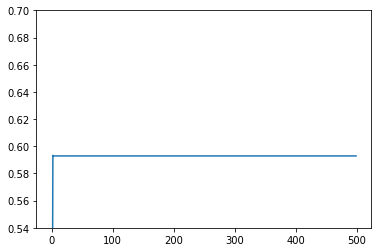

In [ ]:
plt.plot(list(range(len(accuracies))), accuracies)
plt.ylim(0.54, 0.70)

In [ ]:
print(accuracies)

[array([0.40712074]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926]), array([0.59287926])]


In [ ]:
training[-1]

7.676371812820435

In [ ]:
model = NN(linear_input, network_size)
loss = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.3, nesterov=True)
accuracies, training = train(model, loss, optimizer)

Training Loss: 0.689794659614563
Online Accuracy: 0.5928792569659442
Training Loss: 0.4157665967941284
Online Accuracy: 0.5928792569659442
Training Loss: 0.9034053683280945
Online Accuracy: 0.5928792569659442
Training Loss: 0.7575726509094238
Online Accuracy: 0.5928792569659442
Training Loss: 0.9205527305603027
Online Accuracy: 0.5928792569659442
Training Loss: 0.9086704850196838
Online Accuracy: 0.5928792569659442
Training Loss: 1.0788828134536743
Online Accuracy: 0.5928792569659442
Training Loss: 0.5416846871376038
Online Accuracy: 0.5928792569659442
Training Loss: 1.1349914073944092
Online Accuracy: 0.5928792569659442
Training Loss: 0.37236902117729187
Online Accuracy: 0.5928792569659442
Training Loss: 0.5422104597091675
Online Accuracy: 0.5928792569659442
Training Loss: 0.8686397671699524
Online Accuracy: 0.5928792569659442
Training Loss: 0.4790869355201721
Online Accuracy: 0.5928792569659442
Training Loss: 0.6438332200050354
Online Accuracy: 0.5928792569659442
Training Loss: 0.657

(0.5, 0.7)

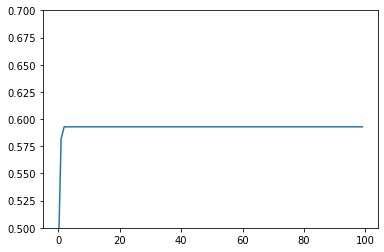

In [ ]:
plt.plot(list(range(len(accuracies))), accuracies)
plt.ylim(0.5, 0.70)

In [ ]:
model = NN(linear_input, network_size)
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
accuracies, training = train(model, loss, optimizer)

Training Loss: 0.6998218297958374
Online Accuracy: 0.5928792569659442
Training Loss: 0.672746479511261
Online Accuracy: 0.5928792569659442
Training Loss: 0.6712293028831482
Online Accuracy: 0.5928792569659442
Training Loss: 0.666480302810669
Online Accuracy: 0.5928792569659442
Training Loss: 0.6735982298851013
Online Accuracy: 0.6219040247678018
Training Loss: 0.6487441062927246
Online Accuracy: 0.5921052631578947
Training Loss: 0.6349790096282959
Online Accuracy: 0.6153250773993808
Training Loss: 0.7123463749885559
Online Accuracy: 0.5928792569659442
Training Loss: 0.6727638840675354
Online Accuracy: 0.5928792569659442
Training Loss: 0.6610059142112732
Online Accuracy: 0.5928792569659442
Training Loss: 0.6604614853858948
Online Accuracy: 0.5928792569659442
Training Loss: 0.6728518009185791
Online Accuracy: 0.5928792569659442
Training Loss: 0.6645734906196594
Online Accuracy: 0.5928792569659442
Training Loss: 0.7097672820091248
Online Accuracy: 0.5928792569659442
Training Loss: 0.67660

(0.5, 0.7)

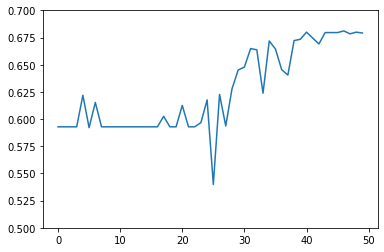

In [ ]:
plt.plot(list(range(len(accuracies))), accuracies)
plt.ylim(0.50, 0.70)